/var/folders/30/cmv9c_5j3mq_kthx63sb1t5c0000gn/T/ipykernel_90810/1692258764.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sorted_data['memory_ratio'] = sorted_data.groupby('index').apply(
/var/folders/30/cmv9c_5j3mq_kthx63sb1t5c0000gn/T/ipykernel_90810/1692258764.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sorted_data['memory_ratio'] = sorted_data.groupby('index').apply(
/var/folders/30/cmv9

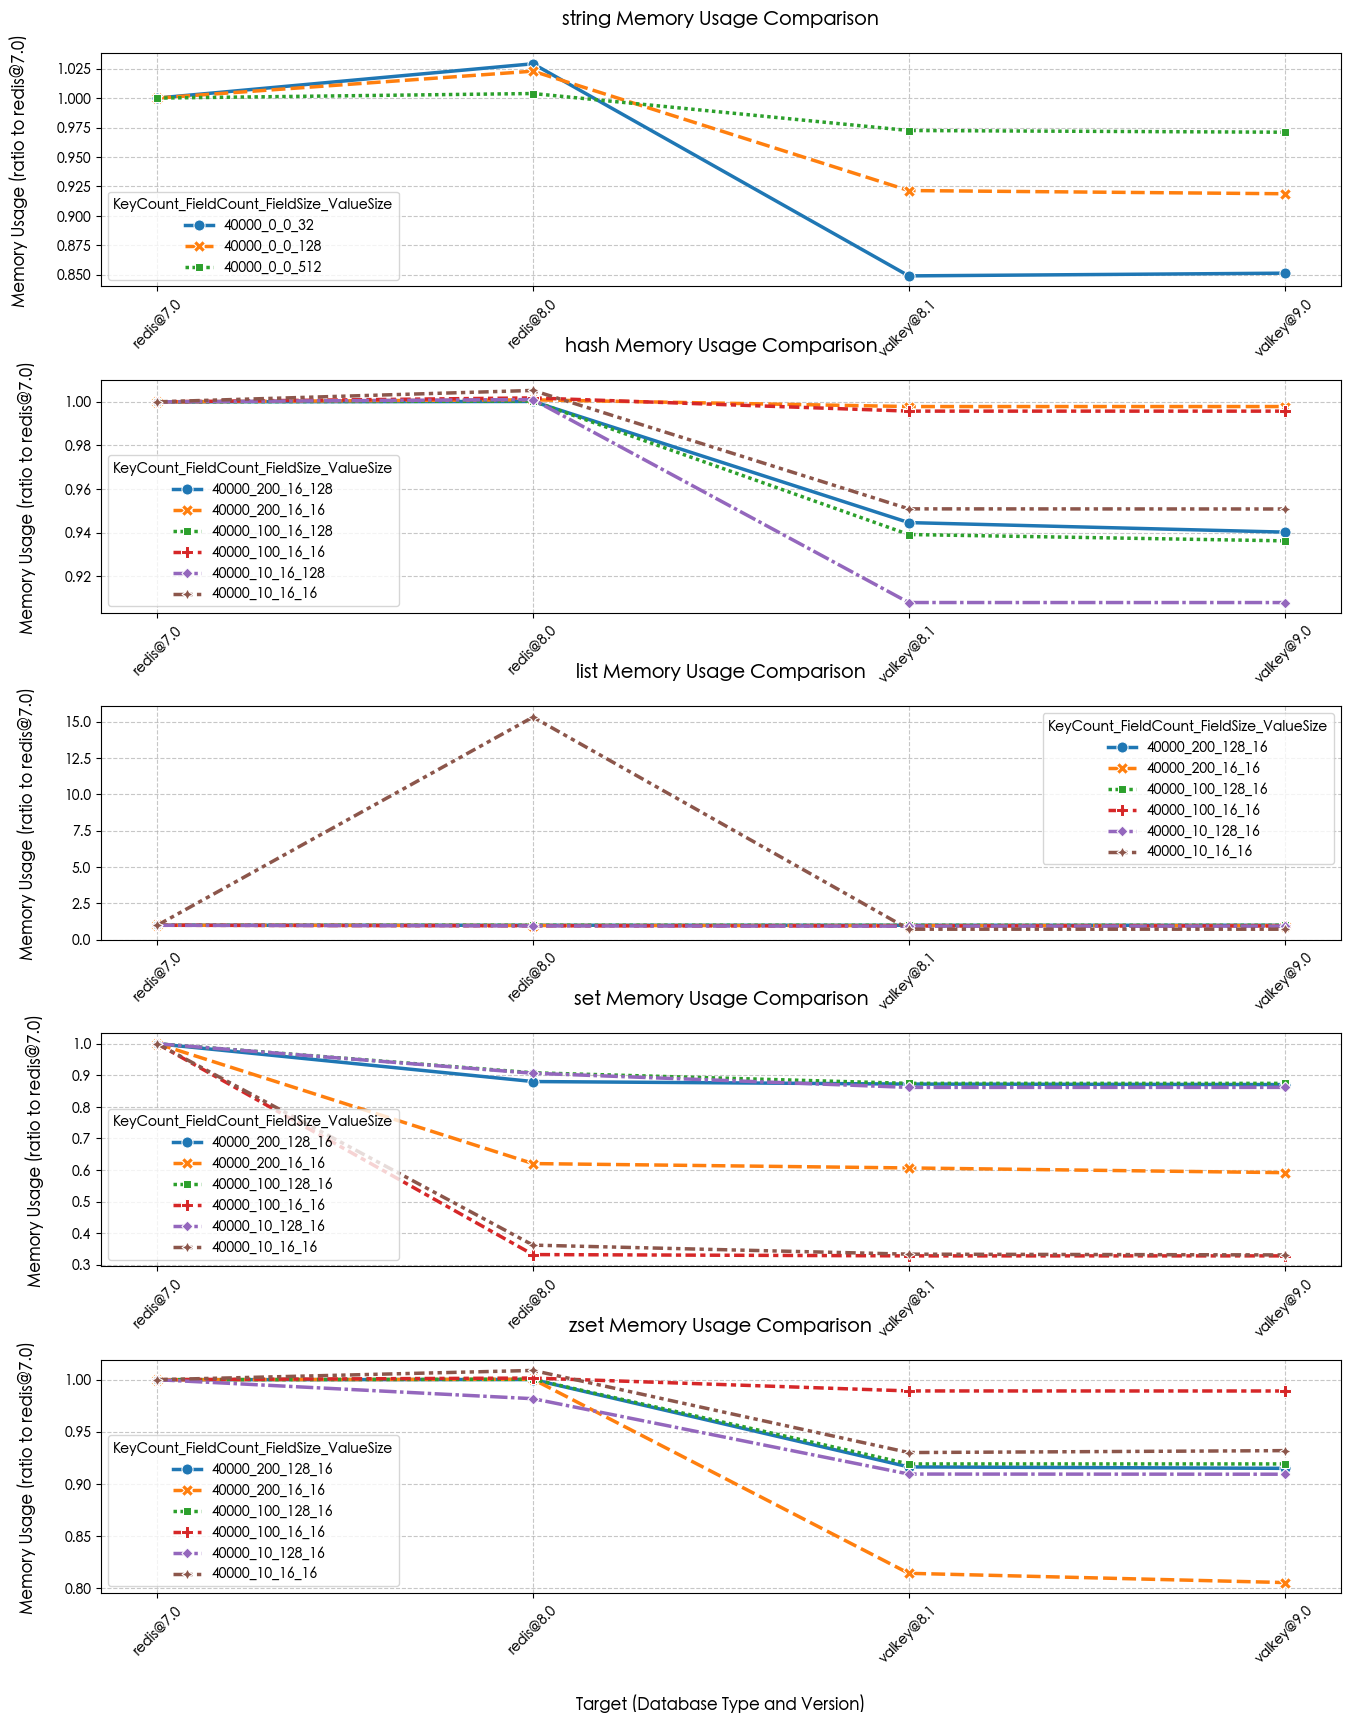

In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

# Set font for Chinese display
plt.rcParams["font.family"] = ["SimHei", "WenQuanYi Micro Hei", "Heiti TC"]
plt.rcParams["axes.unicode_minus"] = False  # Fix negative sign display issue

def load_case_config(case_path):
    with open(case_path, 'r') as f:
        return json.load(f)

def generate_type_visualizations(df, case_config, target_order):
    num_types = len(case_config)
    fig = plt.figure(figsize=(16, 4 * num_types))
    gs = GridSpec(num_types, 1, figure=fig, hspace=0.4)

    plt.rcParams["font.family"] = ["SimHei", "WenQuanYi Micro Hei", "Heiti TC"]
    plt.rcParams['axes.unicode_minus'] = False

    for i, type_config in enumerate(case_config):
        data_type = type_config['type']
        ax = fig.add_subplot(gs[i])

        type_data = df[df['type'] == data_type].copy()
        type_data = type_data[type_data['key_count'] == 160000].copy()
        if type_data.empty:
            ax.text(0.5, 0.5, f'No data for {data_type} type', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'{data_type} Memory Usage Comparison')
            continue

            
        type_data['index'] = (type_data['key_count'].astype(str) + '_' + 
                                type_data['field_count'].astype(str) + '_' + 
                                type_data['field_size'].astype(str) + '_' + 
                                type_data['value_size'].astype(str))

        # Set target order
        type_data['target'] = pd.Categorical(type_data['target'], categories=target_order, ordered=True)
        sorted_data = type_data.sort_values('target')

        # Calculate memory ratio relative to redis7.0
        sorted_data['memory_ratio'] = sorted_data.groupby('index').apply(
            lambda x: (x['used_memory'] / x[x['target'] == 'redis@7.0']['used_memory'].iloc[0])
        ).reset_index(level=0, drop=True)
        
        # Plot multi-configuration comparison curves
        sns.lineplot(data=sorted_data, x='target', y='memory_ratio', 
                     hue='index', style='index',
                     markers=True, dashes=True, linewidth=2.5, 
                     markersize=8, ax=ax)

        # Set chart properties
        ax.set_title(f'{data_type} Memory Usage Comparison', fontsize=14, pad=20)  # Add padding to title
        ax.set_xlabel('Target (Database Type and Version)', fontsize=12, labelpad=20)
        ax.set_ylabel('Memory Usage (ratio to redis@7.0)', fontsize=12, labelpad=20)
        ax.tick_params(axis='x', rotation=45)
        ax.grid(linestyle='--', alpha=0.7)
        ax.legend(title='KeyCount_FieldCount_FieldSize_ValueSize')

    plt.tight_layout()
    return fig

# Load JSON data
with open("./report.json", "r") as f:
    data = json.load(f)

df = pd.DataFrame(data)

case_config = load_case_config('./case.json')
target_order = ['redis@7.0', 'redis@8.0', 'valkey@8.1', 'valkey@9.0']  # Adjust according to actual data

# Generate and display charts for all types
fig = generate_type_visualizations(df, case_config, target_order)
plt.show()